# Imports

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

# Dataset

## Obtaining the dataset

In [2]:
# getting the dataset from the csv file
data = pd.read_csv('Lab6-Proj1_Dataset.csv')

In [3]:
data.tail()

,Anchor_Ratio,Transmission_Range,Node_Density,Step_Size,Iterations,ESLE
280,0.15,18.40,0.01,1.0,6,2.420293
281,0.15,18.40,0.01,1.2,6,2.427482
282,0.18,26.45,0.01,0.9,6,1.690174
283,0.18,26.45,0.01,1.0,6,1.707076
284,0.18,26.45,0.01,1.2,6,1.712146


### Statistical Analysis of the dataset  

In [4]:
# shape
print(data.shape)

# quick statistical analysis of the dataset
data.describe()

(285, 6)


,Anchor_Ratio,Transmission_Range,Node_Density,Step_Size,Iterations,ESLE
count,285.000000,285.000000,285.000000,285.000000,285.000000,2.850000e+02
mean,0.207474,20.554737,0.015158,1.033333,37.536842,1.220366e+00
std,0.065472,3.410259,0.006796,0.124941,24.104881,1.536450e+00
min,0.140000,17.250000,0.010000,0.900000,6.000000,8.900000e-08
25%,0.150000,17.250000,0.010000,0.900000,20.000000,7.837210e-01
50%,0.180000,20.700000,0.010000,1.000000,30.000000,1.054853e+00
75%,0.300000,23.000000,0.020000,1.200000,60.000000,1.360695e+00
max,0.300000,28.750000,0.030000,1.200000,90.000000,2.500000e+01


General Boxplot

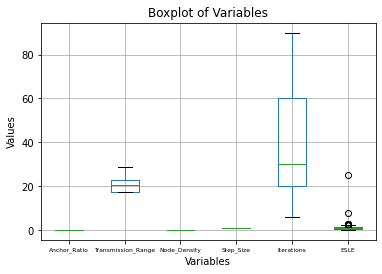

In [5]:
# generating the boxplot
data.boxplot()

# setting the plot title and axes labels
plt.title('Boxplot of Variables')
plt.xlabel('Variables')
plt.ylabel('Values')
plt.xticks(fontsize=6)

# displaying the plot
plt.show()

Individual Boxplots for better visualization

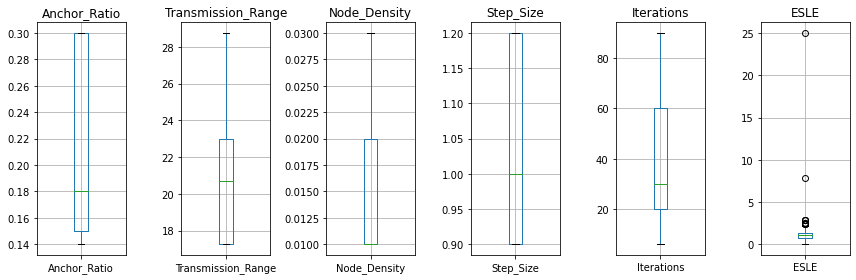

In [6]:
# Determine the number of variables
num_variables = len(data.columns)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=num_variables, figsize=(12, 4))

# Generate individual boxplots for each variable
for i, column in enumerate(data.columns):
    data.boxplot(column=column, ax=axes[i])
    axes[i].set_title(column)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

## Data Preprocessing 

### Data Cleaning

- No incomplete data
- Is there noisy data? (no indication for errors, nor outlier, but might there be outliers?)
- No inconsistent data
- Is there intentional data? (certainly doesn't seem like so)

In [7]:
# Verify if there are any missing values
print(data.isnull().sum())

Anchor_Ratio          0
Transmission_Range    0
Node_Density          0
Step_Size             0
Iterations            0
ESLE                  0
dtype: int64


### Data Integration

- combine data from different sources. are there different sources? (don't think so)
- any different scale / unit problems? (better check)
- any redudant features? (correlation analysis, covariance analysis) (should delve further)

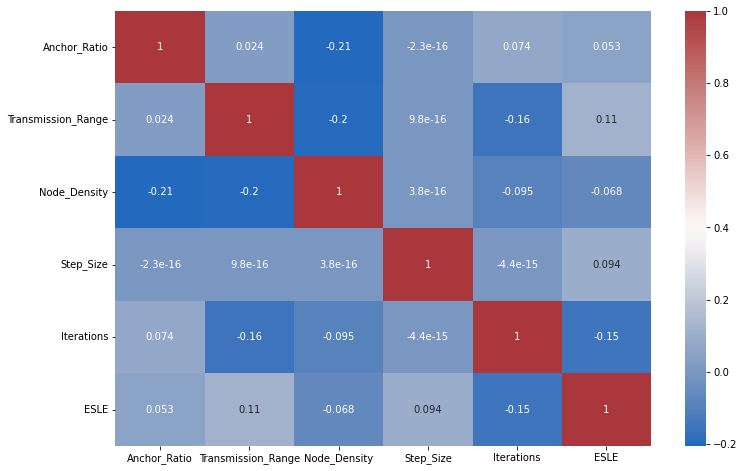

In [8]:
# correlation analysis of the dataset (Pearson's correlation coefficient)
plt.figure(figsize=(12, 8))
# with nice colours, such that 0 always corresponds to white
colour = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(data.corr(), annot=True, cmap=colour)
plt.show()

# other cmap options are: 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
# a colormap such that 0 always corresponds to white is 'coolwarm', 'bwr', 'seismic'

### Data Reduction

### Data transformation and data discretization

# Creating the models

In [9]:
# copy dataset data
data_copy = data.copy()

# split dataset into input and output variables, y is the last column
X = data_copy.iloc[:, :-1]
y = data_copy.iloc[:, -1]

# Define seed for reproducibility
seed = 42

# assuming X and y are your data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### MLP 

Mean Squared Error on Test Data: 0.1807800402237058
Coefficient of determination (regression score function): -0.02


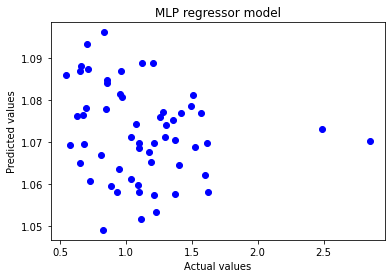

In [10]:


# create MLPRegressor model
model = MLPRegressor(hidden_layer_sizes=(100,), 
                     activation='logistic', 
                     solver='sgd', 
                     early_stopping=True,
                     max_iter=100,
                     validation_fraction=0.2, 
                     n_iter_no_change=10, tol=1e-4)

# train the model
model.fit(X_train, y_train)

# predict on the test data
y_pred = model.predict(X_test)

# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Data: {mse}")

print('Coefficient of determination (regression score function): %.2f' % r2_score(y_test, y_pred))

# plotting the results
plt.scatter(y_test, y_pred, color='blue')
plt.title('MLP regressor model')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()


### CNN

2/2 [==============================] - 0s 6ms/step
Mean Squared Error on Test Data: 0.16248730594612348


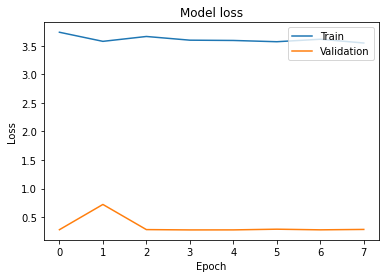

In [21]:
# reshape the data to 3D for CNN input
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# Build the model
model = Sequential()
model.add(Conv1D(32, 2, activation='sigmoid', input_shape=(X_train_cnn.shape[1], 1)))
model.add(Flatten())
model.add(Dense(1))

# Compile the model
model.compile(optimizer='sgd', loss='mean_squared_error', metrics=['mse'])

# Fit the model
history = model.fit(X_train_cnn, 
                    y_train, 
                    validation_split=0.2, 
                    epochs=1000, 
                    batch_size=32, 
                    verbose=0, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

# Predict on the test data
y_pred = model.predict(X_test_cnn)

# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Data: {mse}")

# plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### RNN